In [123]:
import sys
import os
import glob
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list

# Parameters

In [122]:
statistic = 'z_score'
multiple_comp_corr = 'fdr'
alpha = 0.05
run = 'test'
first_level_dir = '/Users/hugofluhr/data/LH_dev/nilearn/first_level_scrubbed_demeaned_basic_motion'

# Load First level data

In [70]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = '/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1'

dev_sub_ids = ['01', '02', '03', '04', '05', '06']
all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [71]:
contrast_modulator_RL_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}_run-{run}_model_rl*_z_map.nii.gz"))[0]
    for sub_id in sub_ids
]
contrast_modulator_CK_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}_run-{run}_model_ck*_z_map.nii.gz"))[0]
    for sub_id in sub_ids
]

contrast_modulator_RL_paths.sort()
contrast_modulator_CK_paths.sort()

assert len(contrast_modulator_RL_paths) == len(sub_ids), "Some subjects are missing RL contrast maps."
assert len(contrast_modulator_CK_paths) == len(sub_ids), "Some subjects are missing CK contrast maps."

print("All subjects are present for both RL and CK.")

All subjects are present for both RL and CK.


In [72]:
contrast_modulator_RL_imgs = [image.load_img(path) for path in contrast_modulator_RL_paths]
contrast_modulator_CK_imgs = [image.load_img(path) for path in contrast_modulator_CK_paths]

## Load masks

In [73]:
mask_dir = '/Users/hugofluhr/data/LH_dev/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Q-value modulation

In [74]:
X_RL = pd.DataFrame([1] * len(contrast_modulator_RL_imgs), columns=['RL_value'])

In [75]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

In [76]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type=statistic)

## Whole brain

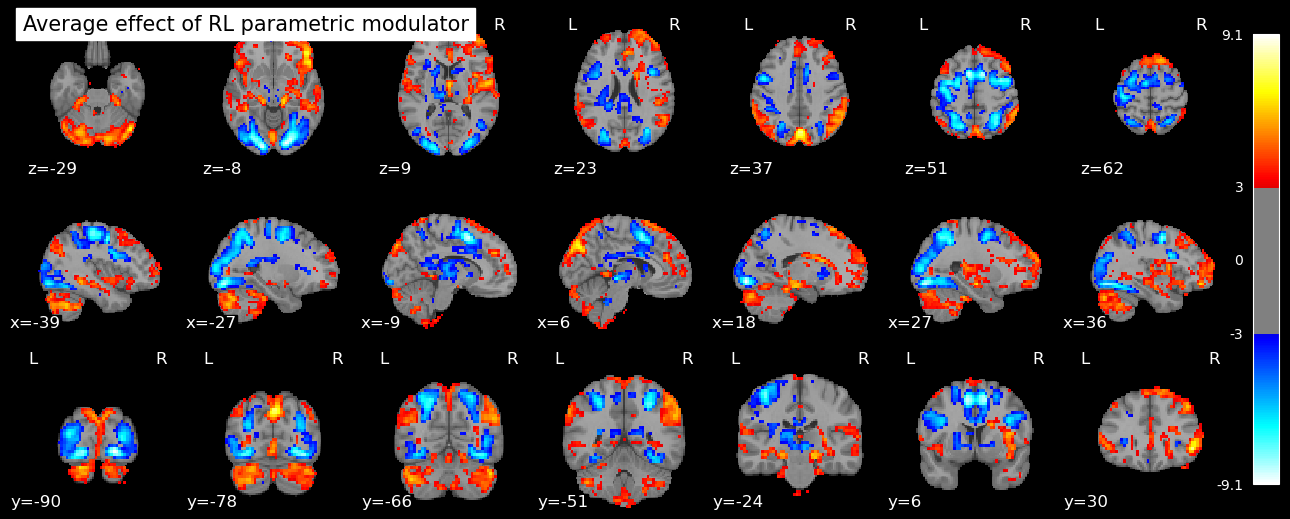

In [77]:
plot_stat_map(RL_WB_zmap, threshold=3, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')


### Correct for multiple comparisons

In [78]:
RL_WB_thresholded_zmap, RL_WB_threshold = threshold_stats_img(RL_WB_zmap, alpha=alpha, height_control='bonferroni', cluster_threshold=30)
print(f"RL whole brain Bonferroni threshold: {RL_WB_threshold:.3f}")

RL whole brain Bonferroni threshold: 4.955


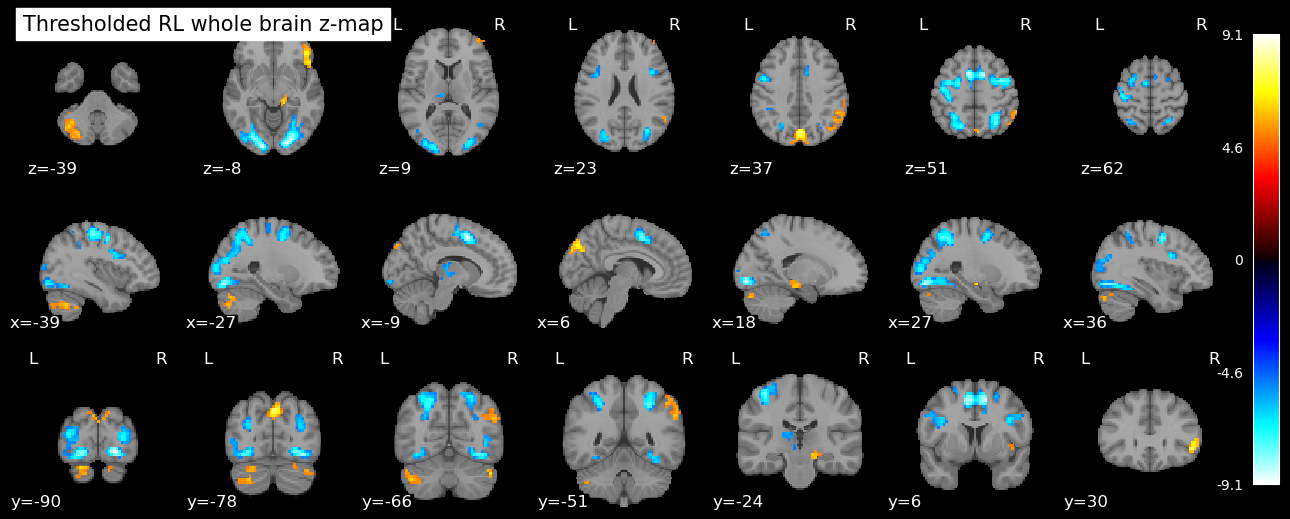

In [79]:
plot_stat_map(RL_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL whole brain z-map')

## ROIs for Q-values: VMPFC

In [80]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
vmpfc_mask = image.resample_to_img(vmpfc_mask, RL_WB_zmap, interpolation='nearest')
vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

In [81]:
vmpfc_second_level = SecondLevelModel(mask_img=vmpfc_masker)
vmpfc_second_level = vmpfc_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [82]:
RL_vmpfc_zmap = vmpfc_second_level.compute_contrast(output_type=statistic)

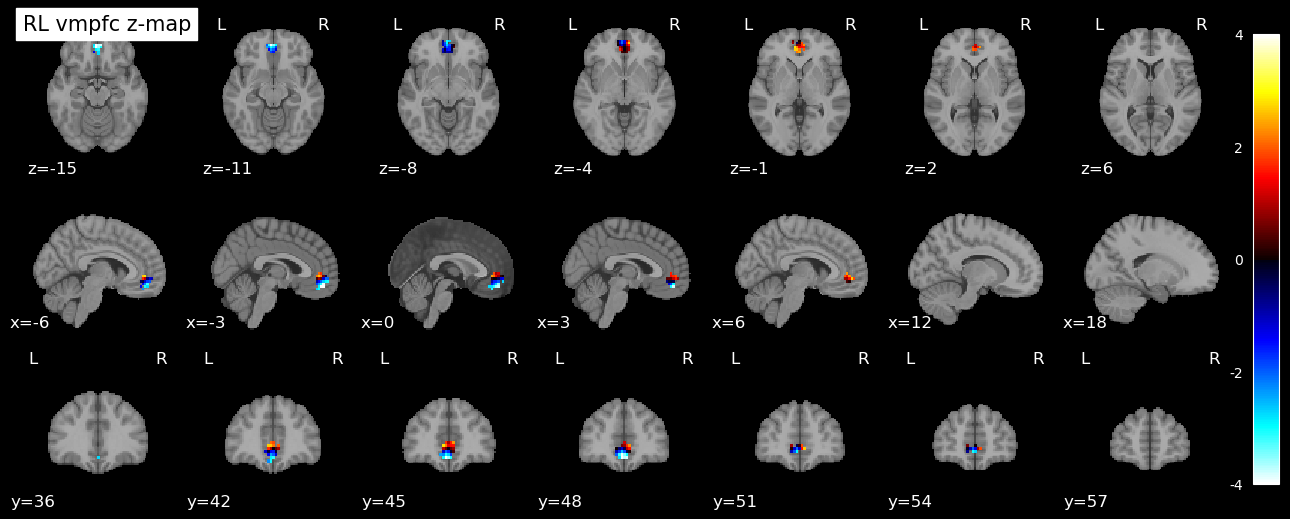

In [83]:
plot_stat_map(RL_vmpfc_zmap, black_bg=True, display_mode='mosaic', title='RL vmpfc z-map')

In [84]:
RL_vmpfc_thresholded_zmap, RL_vmpfc_threshold = threshold_stats_img(RL_vmpfc_zmap, alpha=alpha, height_control=multiple_comp_corr)

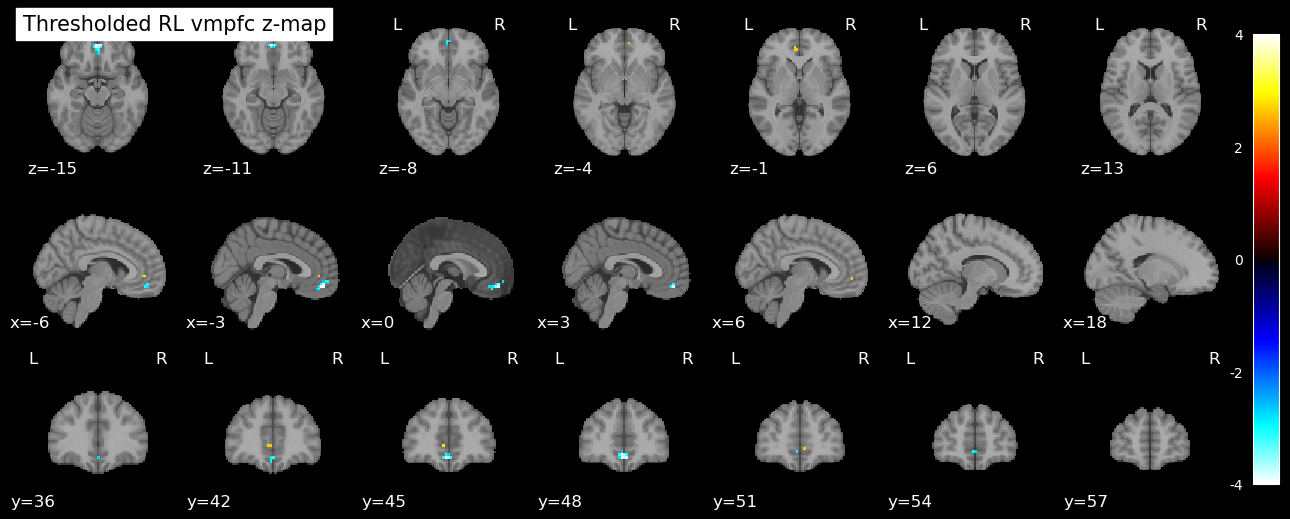

In [85]:
plot_stat_map(RL_vmpfc_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL vmpfc z-map')

In [86]:
vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)

## ROIs for Q-values: Striatum

In [87]:
striatum_mask = image.load_img(striatum_mask_path)
striatum_mask = image.resample_to_img(striatum_mask, RL_WB_zmap, interpolation='nearest')
striatum_masker = NiftiMasker(mask_img=striatum_mask)

In [88]:
striatum_second_level = SecondLevelModel(mask_img=striatum_masker)
striatum_second_level = striatum_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [89]:
RL_striatum_zmap = striatum_second_level.compute_contrast(output_type=statistic)

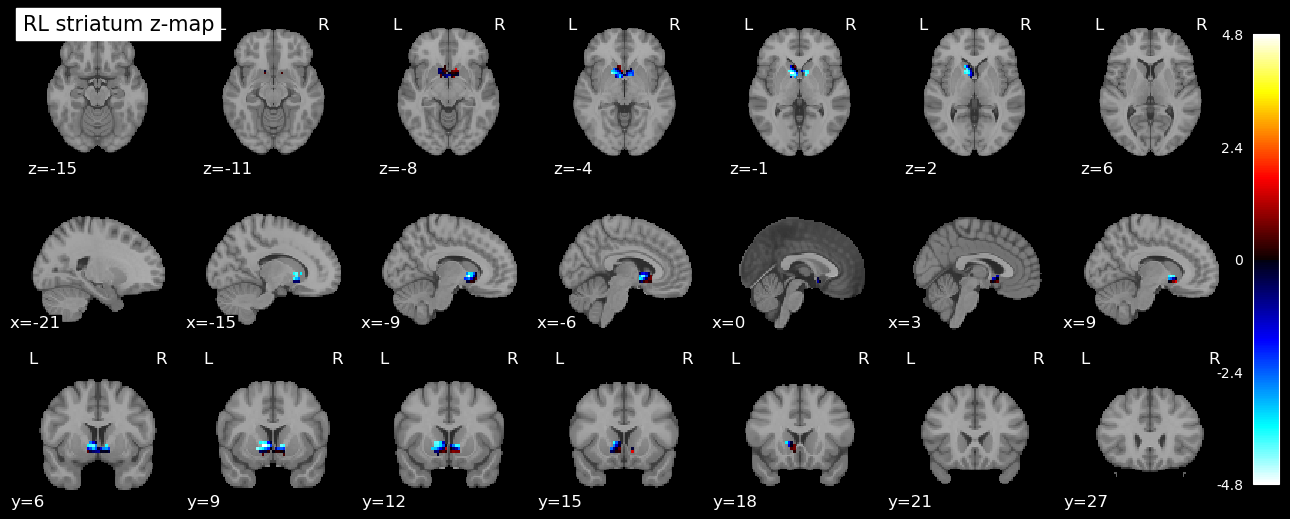

In [90]:
plot_stat_map(RL_striatum_zmap, black_bg=True, display_mode='mosaic', title='RL striatum z-map')

In [91]:
RL_striatum_thresholded_zmap, RL_striatum_threshold = threshold_stats_img(RL_striatum_zmap, alpha=alpha, height_control=multiple_comp_corr)

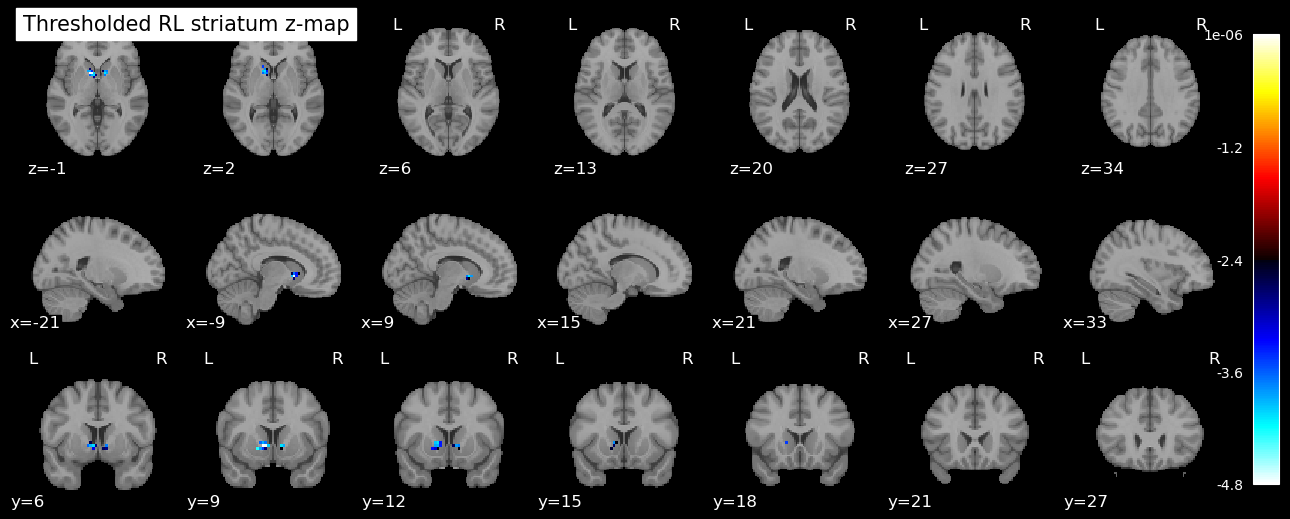

In [92]:
plot_stat_map(RL_striatum_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL striatum z-map')

In [93]:
striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)

/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_3169/2531939775.py:1: UserWarning: Attention: No clusters with stat higher than 2.434103400396346
  striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)


# H-value modulation

In [94]:
X_CK = pd.DataFrame([1] * len(contrast_modulator_CK_imgs), columns=['CK_value'])

In [95]:
second_level_model_CK = SecondLevelModel()
second_level_model_CK = second_level_model_CK.fit(contrast_modulator_CK_imgs, design_matrix=X_RL)

In [96]:
CK_WB_zmap = second_level_model_CK.compute_contrast(output_type=statistic)

## Whole brain

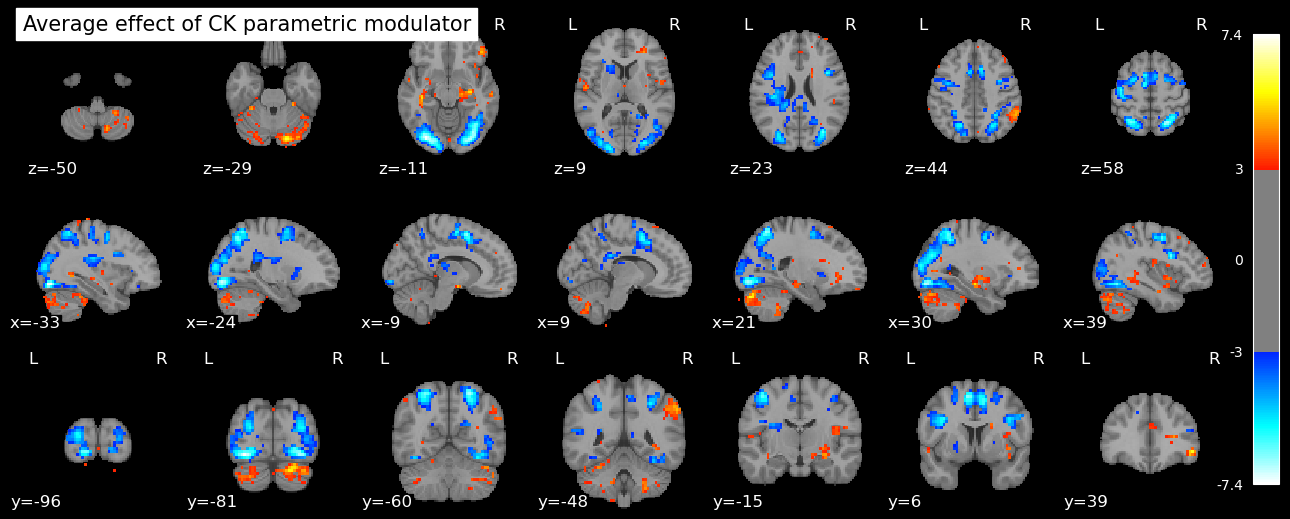

In [97]:
plot_stat_map(CK_WB_zmap, threshold=3, black_bg=True, display_mode='mosaic', title='Average effect of CK parametric modulator')


### Correct for multiple comparisons

In [98]:
CK_WB_thresholded_zmap, CK_WB_threshold = threshold_stats_img(CK_WB_zmap, alpha=alpha, height_control='bonferroni', cluster_threshold=1)
print(f"CK whole brain Bonferroni threshold: {CK_WB_threshold:.3f}")

CK whole brain Bonferroni threshold: 4.955


In [99]:
np.corrcoef(CK_WB_zmap.get_fdata().flatten(), RL_WB_zmap.get_fdata().flatten())

array([[1.       , 0.8649051],
       [0.8649051, 1.       ]])

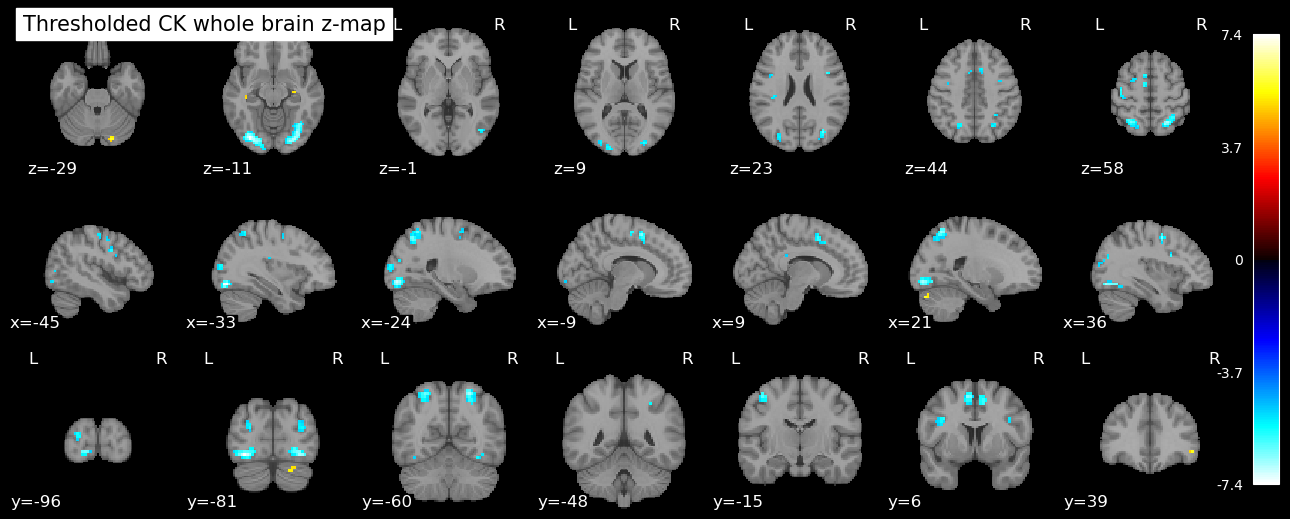

In [100]:
plot_stat_map(CK_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK whole brain z-map')

## ROIs for H-values: putamen

In [101]:
putamen_mask = image.load_img(putamen_mask_path)
putamen_mask = image.resample_to_img(putamen_mask, RL_WB_zmap, interpolation='nearest')
putamen_masker = NiftiMasker(mask_img=putamen_mask)

In [102]:
putamen_second_level = SecondLevelModel(mask_img=putamen_masker)
putamen_second_level = putamen_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [103]:
CK_putamen_zmap = putamen_second_level.compute_contrast(output_type=statistic)

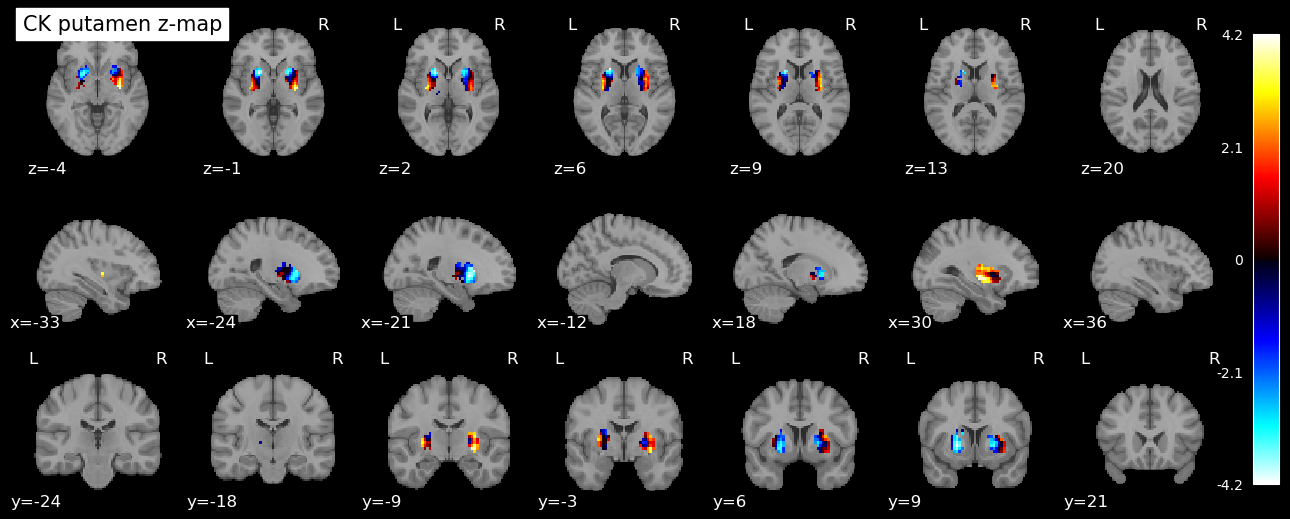

In [104]:
plot_stat_map(CK_putamen_zmap, black_bg=True, display_mode='mosaic', title='CK putamen z-map')

In [105]:
CK_putamen_thresholded_zmap, CK_putamen_threshold = threshold_stats_img(CK_putamen_zmap, alpha=alpha, height_control=multiple_comp_corr)

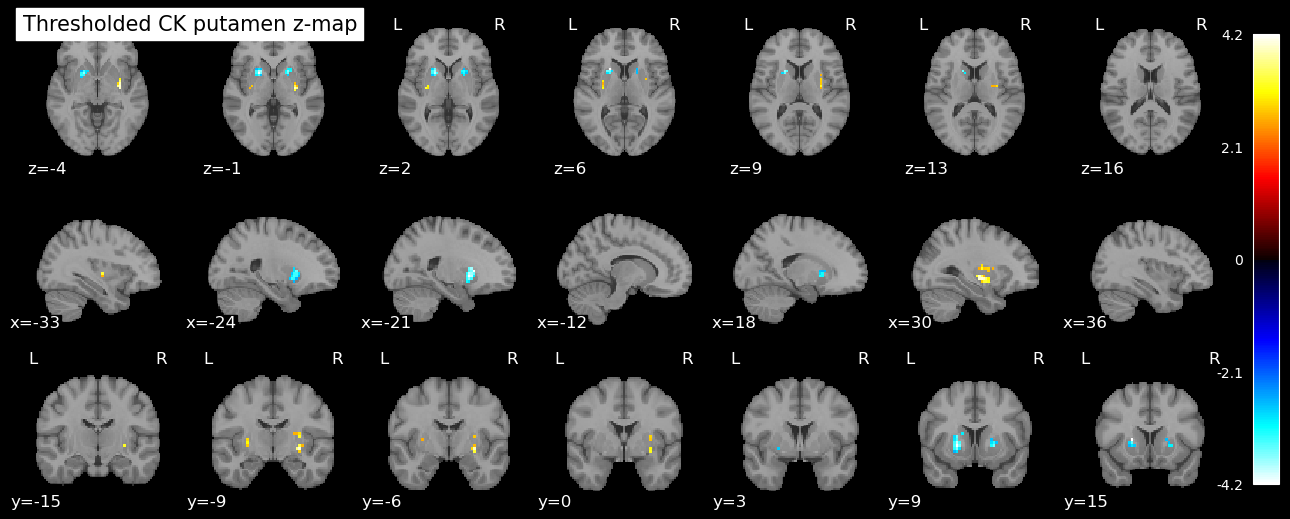

In [106]:
plot_stat_map(CK_putamen_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK putamen z-map')

In [107]:
putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
putamen_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,30.0,-9.0,-4.5,3.994571,535
1,2,-33.0,-12.0,2.5,3.290601,283
2,2a,-30.0,-3.0,6.0,3.005205,
3,3,30.0,-9.0,9.5,3.245487,283
4,3a,30.0,0.0,9.5,2.840946,
5,4,30.0,6.0,9.5,2.604365,31
6,1,-21.0,9.0,-1.0,-4.163119,1417
7,1a,-21.0,15.0,6.0,-4.155054,
8,2,21.0,12.0,-1.0,-3.674765,598
9,3,-15.0,9.0,13.0,-2.994693,31


## ROIs for H-values: parietal cortex

In [108]:
parietal_mask = image.load_img(parietal_mask_path)
parietal_mask = image.resample_to_img(parietal_mask, RL_WB_zmap, interpolation='nearest')
parietal_masker = NiftiMasker(mask_img=parietal_mask)

In [109]:
parietal_second_level = SecondLevelModel(mask_img=parietal_masker)
parietal_second_level = parietal_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [110]:
CK_parietal_zmap = parietal_second_level.compute_contrast(output_type=statistic)

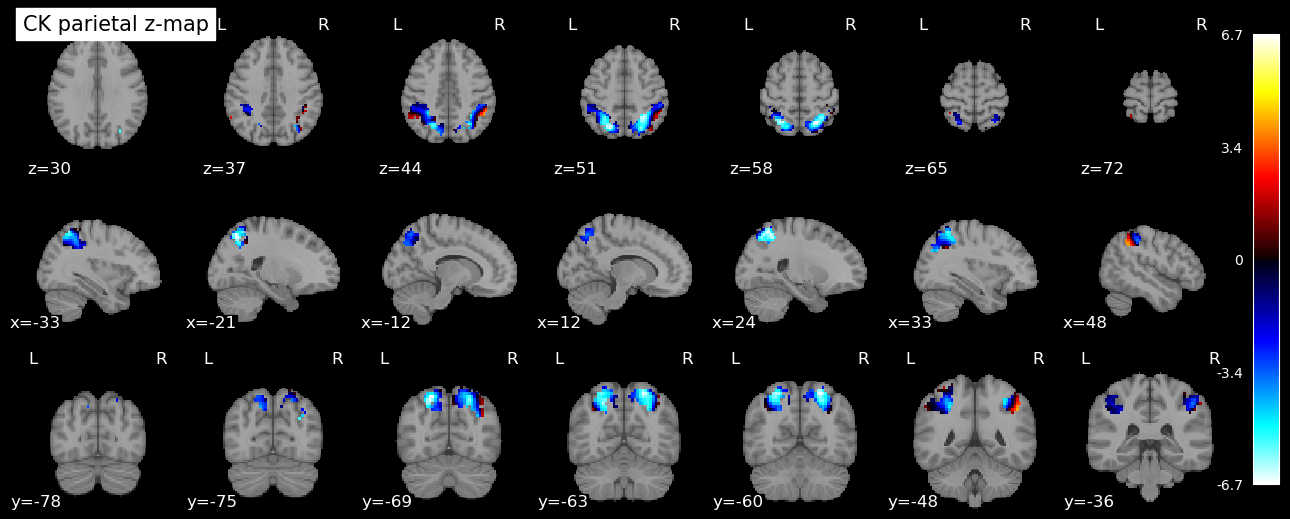

In [111]:
plot_stat_map(CK_parietal_zmap, black_bg=True, display_mode='mosaic', title='CK parietal z-map')

In [112]:
CK_parietal_thresholded_zmap, CK_parietal_threshold = threshold_stats_img(CK_parietal_zmap, alpha=alpha, height_control=multiple_comp_corr)

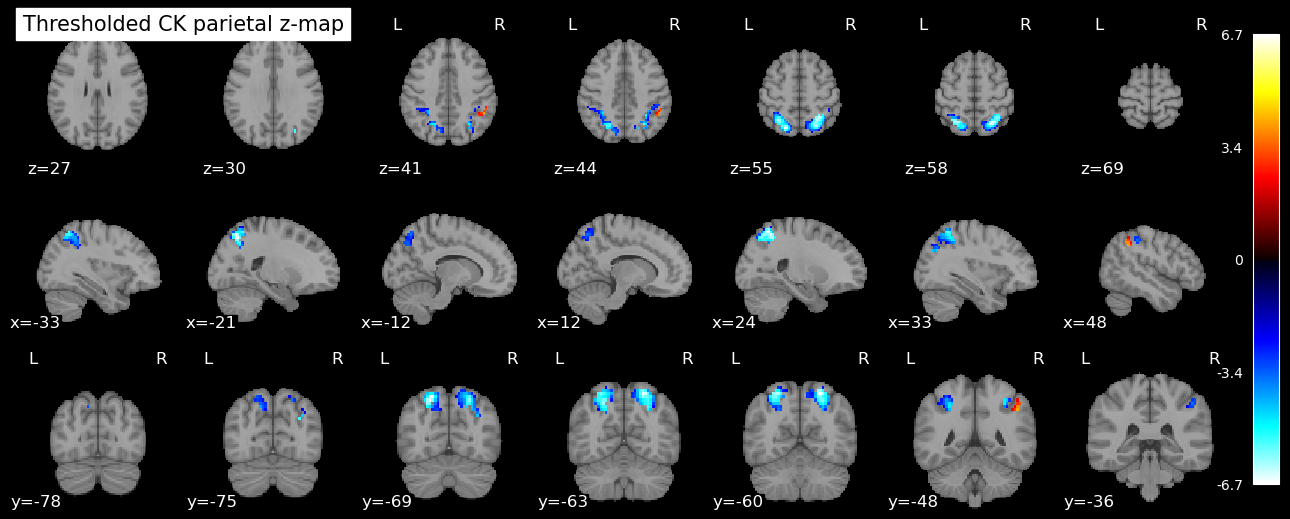

In [113]:
plot_stat_map(CK_parietal_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK parietal z-map')

In [114]:
parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)

# ROI results

In [115]:
vmpfc_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.0,45.0,-1.0,2.818081,94
1,2,6.0,51.0,-4.5,2.640533,31
2,1,-3.0,48.0,-15.0,-3.969522,787
3,1a,-3.0,54.0,-8.0,-3.020489,


In [116]:
# Add ROI information to each table
vmpfc_table['ROI'] = 'VMPFC'
striatum_table['ROI'] = 'Striatum'
putamen_table['ROI'] = 'Putamen'
parietal_table['ROI'] = 'Parietal Cortex'

# Combine the tables
combined_table = pd.concat([vmpfc_table, striatum_table, putamen_table, parietal_table])
combined_table['Coordinates (MNI)'] = combined_table[['X', 'Y', 'Z']].apply(lambda row: tuple(row), axis=1)
combined_table = combined_table[['ROI', 'Cluster ID', 'Coordinates (MNI)', 'Cluster Size (mm3)', 'Peak Stat']]

# Filter out secondary peaks
combined_table = combined_table[~combined_table['Cluster ID'].str.contains('[a-zA-Z]', na=False)]

In [117]:
voxel_volume = np.prod(np.abs(np.diag(RL_WB_zmap.affine)[:3]))
voxel_volume

31.5

In [118]:
combined_table['Cluster Size (voxels)'] = np.round(combined_table['Cluster Size (mm3)'].astype('float') / voxel_volume).astype('int')
combined_table

,ROI,Cluster ID,Coordinates (MNI),Cluster Size (mm3),Peak Stat,Cluster Size (voxels)
0,VMPFC,1,"(-6.0, 45.0, -1.0)",94,2.818081,3
1,VMPFC,2,"(6.0, 51.0, -4.5)",31,2.640533,1
2,VMPFC,1,"(-3.0, 48.0, -15.0)",787,-3.969522,25
0,Striatum,1,"(-12.0, 9.0, -1.0)",976,-4.848167,31
1,Striatum,2,"(9.0, 9.0, -1.0)",315,-4.139416,10
2,Striatum,3,"(-15.0, 18.0, 2.5)",31,-3.514072,1
0,Putamen,1,"(30.0, -9.0, -4.5)",535,3.994571,17
1,Putamen,2,"(-33.0, -12.0, 2.5)",283,3.290601,9
3,Putamen,3,"(30.0, -9.0, 9.5)",283,3.245487,9
5,Putamen,4,"(30.0, 6.0, 9.5)",31,2.604365,1


In [119]:
# to see number of voxels in each mask:
np.unique(vmpfc_mask.get_fdata(), return_counts=True)

(array([0., 1.]), array([165241,    119]))

In [120]:
final_table = combined_table.copy()
final_table = final_table[final_table['Cluster Size (voxels)'] >= 10]
final_table

,ROI,Cluster ID,Coordinates (MNI),Cluster Size (mm3),Peak Stat,Cluster Size (voxels)
2,VMPFC,1,"(-3.0, 48.0, -15.0)",787,-3.969522,25
0,Striatum,1,"(-12.0, 9.0, -1.0)",976,-4.848167,31
1,Striatum,2,"(9.0, 9.0, -1.0)",315,-4.139416,10
0,Putamen,1,"(30.0, -9.0, -4.5)",535,3.994571,17
6,Putamen,1,"(-21.0, 9.0, -1.0)",1417,-4.163119,45
8,Putamen,2,"(21.0, 12.0, -1.0)",598,-3.674765,19
0,Parietal Cortex,1,"(48.0, -48.0, 41.0)",693,4.130306,22
1,Parietal Cortex,1,"(24.0, -60.0, 58.5)",9796,-6.710964,311
4,Parietal Cortex,2,"(-21.0, -69.0, 51.5)",9040,-6.638156,287


In [121]:
#final_table.to_csv('final_table.csv', index=False)